In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix


In [27]:
path_to_files = "stock_data/"
# path_to_sentiments1 = "stock_news_sentiment_scores/2011-2024/stock_news_sentiment_analysis_results_"
path_to_sentiments = "stock_news_sentiment_scores/2011-2024/stock_news_sentiment_analysis_results_"
path_to_global_news = "news_sentiment_scores/2000-2024/sentiment_analysis_results_"

stock_symbols = ['GOOG', 'MSFT', 'NVDA','AMZN','AAPL']

interval = 14 # Time interval for Standard Moving Average calculation 
start_date = pd.to_datetime('2012-01-01').date()
end_date = pd.to_datetime('2022-01-01').date()



In [28]:
# def categorize_change(diff):
#     # Replace this function with your logic for categorizing changes
#     return diff

# def categorize_change(x):
#     if pd.isnull(x):
#         return None  # For the first day
#     elif x > 0:
#         return 1
#     else:
#         return 0

# def preprocess_and_merge_data(stock_symbols, start_date, end_date, interval):
#     merged_data = {}

#     for symbol in stock_symbols:
#         # Load data
#         df_sentiment = pd.read_csv(path_to_sentiments + symbol + ".csv")
#         df_stock = pd.read_csv(path_to_files + symbol + "/stock_price.csv")
#         df_news = pd.read_csv(path_to_global_news+symbol+".csv") 

#         # Convert date columns
#         df_sentiment['Date'] = pd.to_datetime(df_sentiment['Date'], utc=True).dt.date
#         df_stock['Date'] = pd.to_datetime(df_stock['Date'], utc=True).dt.date
#         df_news['Date'] = pd.to_datetime(df_news['Date'], utc=True).dt.date
        
#         rename_mapping1 = {'weighted positive sentiment score': 'Stock +ve Sentiment',
#                           'weighted negative sentiment score': 'Stock -ve Sentiment',
#                           'weighted neutral sentiment score': 'Stock Neutral',
#                           'weighted compound sentiment score': 'Stock Sentiment',
#         }
#         rename_mapping2 = {'weighted positive sentiment score': 'Global +ve Sentiment',
#                           'weighted negative sentiment score': 'Global -ve Sentiment',
#                           'weighted neutral sentiment score': 'Global Neutral',
#                           'weighted compound sentiment score': 'News Sentiment',
#         }
#         df_sentiment = df_sentiment.rename(columns=rename_mapping1)
#         df_news = df_news.rename(columns=rename_mapping2)
#         # Filter by date range
#         sentiment_filtered = df_sentiment[(df_sentiment['Date'] >= start_date) & (df_sentiment['Date'] <= end_date)]
#         stock_filtered = df_stock[(df_stock['Date'] >= start_date) & (df_stock['Date'] <= end_date)]
#         news_filtered = df_news[(df_stock['Date'] >= start_date) & (df_news['Date'] <= end_date)]

#         # Align by common dates
#         common_dates = sentiment_filtered['Date'][sentiment_filtered['Date'].isin(stock_filtered['Date'])]
#         sentiment_aligned = sentiment_filtered[sentiment_filtered['Date'].isin(common_dates)]
#         stock_aligned = stock_filtered[stock_filtered['Date'].isin(common_dates)]

#         # Merge and add features
#         full_data = pd.concat([stock_aligned.reset_index(drop=True), sentiment_aligned.reset_index(drop=True)], axis=1)
#         # Compute SMA and Price difference
#         full_data['SMA'] = full_data['Close'].rolling(window= interval).mean()
#         # full_data['SMA'] = full_data['Close'].iloc[i:i + interval].mean()

#         full_data['Difference'] = full_data['Close'].diff()
#         full_data['Trend'] = full_data['Close'].diff().apply(categorize_change)

#         X_features_ = full_data.keys() 
#         merged_data[symbol] = full_data.dropna()  # Drop NA after adding features
    
#     return merged_data, X_features_




In [29]:
def preprocess_and_merge_data(stock_symbols, start_date, end_date, interval):
    merged_data = {}
    X_features_ = None

    for symbol in stock_symbols:
        # Load data
        df_sentiment = pd.read_csv(path_to_sentiments + symbol + ".csv")
        df_stock = pd.read_csv(path_to_files + symbol + "/stock_price.csv")
        df_news = pd.read_csv(path_to_global_news + symbol + ".csv") 

        # Convert date columns
        df_sentiment['Date'] = pd.to_datetime(df_sentiment['Date'], utc=True).dt.date
        df_stock['Date'] = pd.to_datetime(df_stock['Date'], utc=True).dt.date
        df_news['Date'] = pd.to_datetime(df_news['Date'], utc=True).dt.date
        
        # Rename columns
        rename_mapping1 = {
            'weighted positive sentiment score': 'Stock +ve Sentiment',
            'weighted negative sentiment score': 'Stock -ve Sentiment',
            'weighted neutral sentiment score': 'Stock Neutral',
            'weighted compound sentiment score': 'Stock Sentiment',
        }
        rename_mapping2 = {
            'weighted positive sentiment score': 'Global +ve Sentiment',
            'weighted negative sentiment score': 'Global -ve Sentiment',
            'weighted neutral sentiment score': 'Global Neutral',
            'weighted compound sentiment score': 'News Sentiment',
        }
        df_sentiment = df_sentiment.rename(columns=rename_mapping1)
        df_news = df_news.rename(columns=rename_mapping2)
        
        # Filter by date range
        sentiment_filtered = df_sentiment[(df_sentiment['Date'] >= start_date) & (df_sentiment['Date'] <= end_date)]
        stock_filtered = df_stock[(df_stock['Date'] >= start_date) & (df_stock['Date'] <= end_date)]
        news_filtered = df_news[(df_news['Date'] >= start_date) & (df_news['Date'] <= end_date)]

        # Remove 'Ticker' column
        sentiment_filtered = sentiment_filtered.drop(columns=['Ticker'])
        news_filtered = news_filtered.drop(columns=['Ticker'])
        
        # Merge stock and sentiment data on common dates
        merged_df = pd.merge(stock_filtered, sentiment_filtered, on='Date', how='inner')

        # Merge news data, filling missing values with zeros
        merged_df = pd.merge(merged_df, news_filtered, on='Date', how='left')
        news_columns = news_filtered.columns.tolist()
        news_columns.remove('Date')
        merged_df[news_columns] = merged_df[news_columns].fillna(0)

        # Add features
        merged_df['SMA'] = merged_df['Close'].rolling(window= interval).mean()
        # full_data['SMA'] = full_data['Close'].iloc[i:i + interval].mean()

        merged_df['Difference'] = merged_df['Close'].diff()
        merged_df['Trend'] = merged_df['Close'].diff().apply(categorize_change)

        X_features_ = merged_df.columns.tolist()
        merged_data[symbol] = merged_df.dropna()  # Drop NA after adding features
        
    return merged_data, X_features_


In [50]:
stock_data, Xfeatures = preprocess_and_merge_data(stock_symbols, start_date, end_date, interval)

print(Xfeatures)

Features = ['Volume', 'Stock Sentiment', 'News Sentiment']
Stock_Metrics = ['SMA']
Trends = ['Trend']

print(type(stock_data['GOOG']))
print(stock_data['GOOG'].shape)



['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Stock +ve Sentiment', 'Stock -ve Sentiment', 'Stock Neutral', 'Stock Sentiment', 'Global +ve Sentiment', 'Global -ve Sentiment', 'Global Neutral', 'News Sentiment', 'SMA', 'Difference', 'Trend']
<class 'pandas.core.frame.DataFrame'>
(629, 19)


In [51]:
stock_data['GOOG']

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Stock +ve Sentiment,Stock -ve Sentiment,Stock Neutral,Stock Sentiment,Global +ve Sentiment,Global -ve Sentiment,Global Neutral,News Sentiment,SMA,Difference,Trend
13,2012-07-30,15.803062,15.965799,15.640322,15.709890,87795852,0.0,0.0,0.11100,0.000000,0.889000,0.653000,0.0,0.000000,0.000000,0.000000,15.316371,0.533685,1.0
14,2012-08-13,16.085557,16.401843,16.067172,16.398365,131205956,0.0,0.0,0.03100,0.099395,0.909898,-0.582518,0.0,0.000000,0.000000,0.000000,15.383011,0.688475,1.0
15,2012-09-11,17.341254,17.408089,17.168329,17.197895,75232938,0.0,0.0,0.11100,0.057000,0.832000,0.624900,0.0,0.000000,0.000000,0.000000,15.476395,0.799530,1.0
16,2012-09-24,18.162153,18.635214,18.143520,18.618816,143086320,0.0,0.0,0.28200,0.000000,0.718000,0.962200,0.0,0.270101,0.778891,-0.376388,15.766361,1.420921,1.0
17,2012-10-18,18.771866,18.868266,16.795644,17.267712,499561487,0.0,0.0,0.15256,0.118161,0.819924,0.164248,0.0,0.000000,0.000000,0.000000,15.989102,-1.351105,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,2021-12-27,147.102240,148.062878,146.889262,147.701263,13256000,0.0,0.0,0.13000,0.130000,0.870000,-0.070900,0.0,0.000000,0.000000,0.000000,145.659498,0.919235,1.0
638,2021-12-28,148.011012,148.011012,145.577992,146.089233,18624000,0.0,0.0,0.00000,0.280514,0.720200,-0.318200,0.0,0.000000,0.000000,0.000000,145.939347,-1.612030,0.0
639,2021-12-29,146.070786,146.823180,145.148049,146.145599,17022000,0.0,0.0,0.27400,0.000000,0.884749,0.526700,0.0,0.000000,0.000000,0.000000,146.132304,0.056366,1.0
640,2021-12-30,146.091219,146.702222,145.401416,145.644821,12978000,0.0,0.0,0.22300,0.000000,0.777000,0.318200,0.0,0.000000,0.000000,0.000000,145.987374,-0.500778,0.0


In [52]:
# g = sns.pairplot(stock_data['GOOG'], x_vars=Features, y_vars=Targets)
# names = df.columns.map(lambda t: t.split('(')[0])
# for i in range(8):
#     g.axes[0,i].xaxis.set_label_text(names[i])
#     g.axes[0,i].yaxis.set_label_text(names[8])
# plt.show()
# # plt.show()

In [53]:
# plt.scatter(stock_data['GOOG']['weighted compound sentiment score'], stock_data['GOOG']['Price Difference'])

In [54]:
def train_predict(data, features, target):
    results = {}

    for ticker, df in data.items():
        # Prepare data
        X = df[features]
        y = df[target]

        # Train-test split
        # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
        split_index = int(len(df) * 0.9)
        # print(len(df), split_index)
        train_data = df.iloc[:split_index]
        test_data = df.iloc[split_index:]

        # Separate features (X) and target (y)
        X_train = train_data[features]
        y_train = train_data[target]
        X_test = test_data[features]
        y_test = test_data[target]

        # Train XGBoost Model
        model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=10)
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)

        # Evaluation
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred) 
        print(f"{ticker} - MSE: {mse:.4f}, MAE: {mae:.4f}")

        # Store Results
        results[ticker] = {
            'model': model,
            'mse': mse,
            'mae': mae,
            'y_test': y_test,
            'y_pred': y_pred
        }

    return results

def plot_predictions(results, target):
    for ticker, result in results.items():
        plt.figure(figsize=(10, 5))
        plt.plot(result['y_test'].values, label='Actual', marker='o', color = "RoyalBlue")
        plt.plot(result['y_pred'], label='Predicted', marker='x' , color = "Red")
        plt.title(f'{ticker} - Predicted vs Actual ({target})')
        plt.legend()
        plt.show()



In [57]:
results = []

for target in Stock_Metrics:
    print(target)
    res = train_predict(stock_data, Features, target)
    
    results.append(res)

SMA
GOOG - MSE: 2371.3449, MAE: 41.0465
MSFT - MSE: 21684.9052, MAE: 132.0133
NVDA - MSE: 309.5857, MAE: 15.9466
AMZN - MSE: 3493.0090, MAE: 45.8141
AAPL - MSE: 2441.8287, MAE: 40.3273


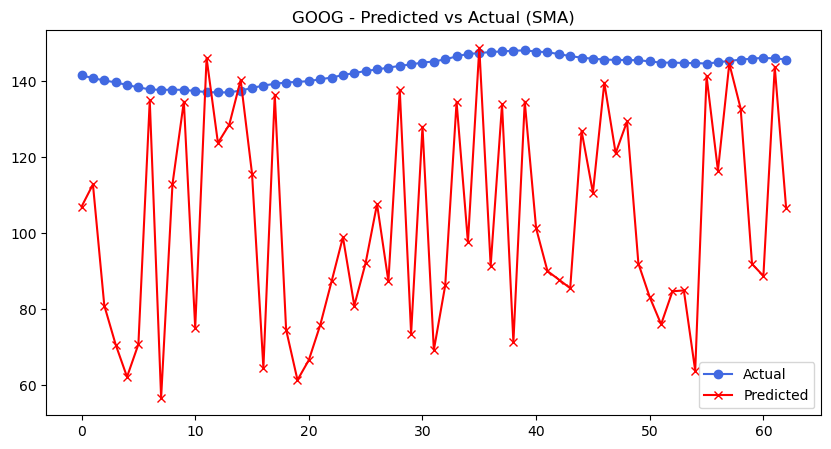

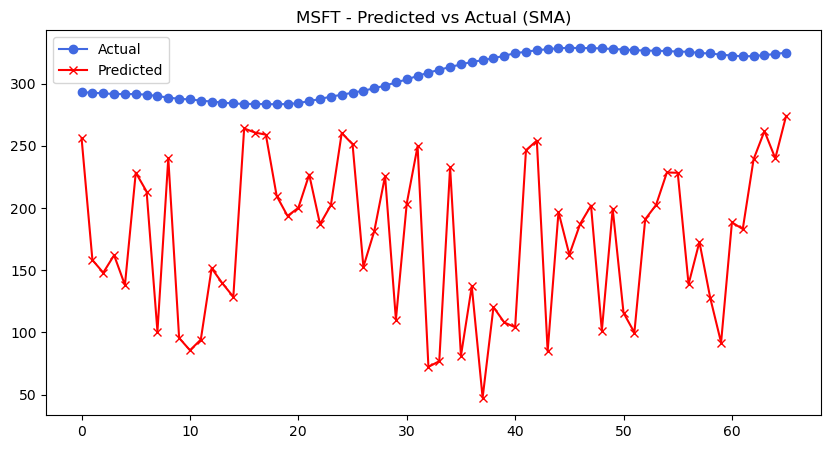

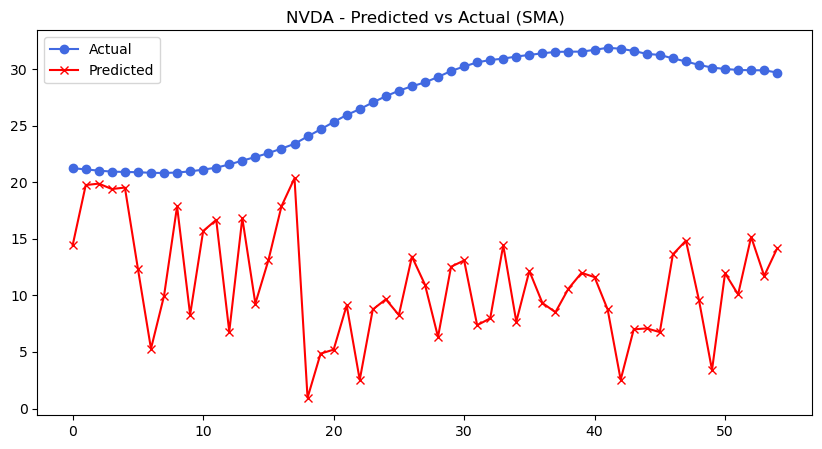

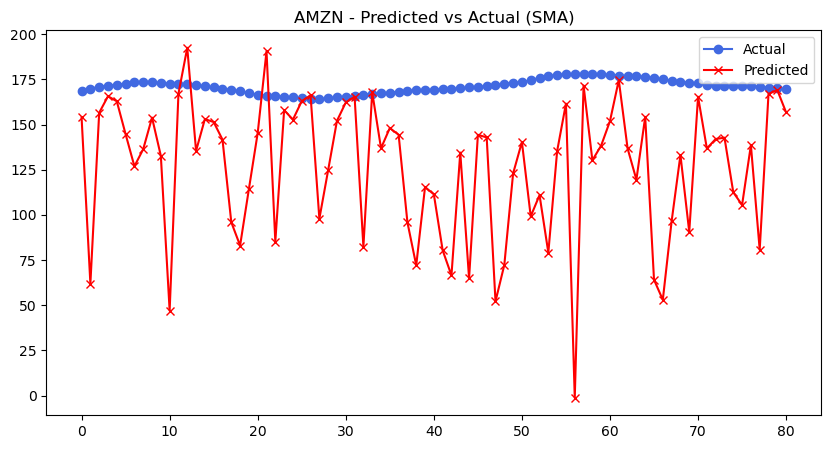

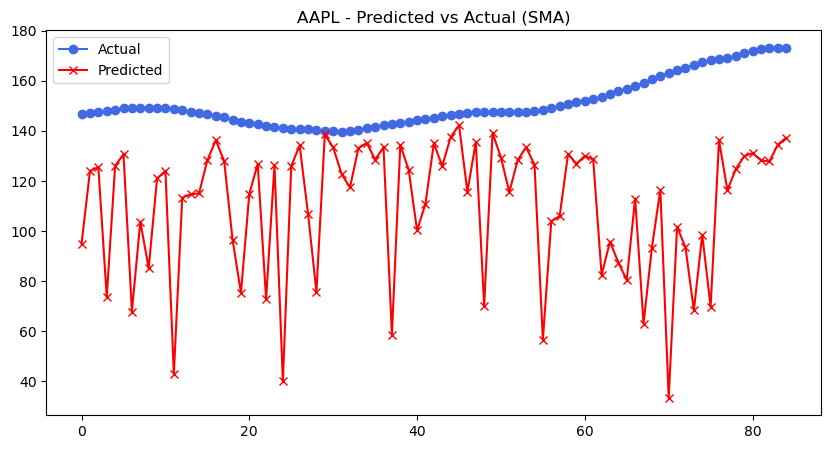

In [58]:
k = 0
plot_predictions(results[k], Stock_Metrics[k])

In [19]:
def train_predict_trend(data, features, target):
    results = {}

    for ticker, df in data.items():
        # Prepare data
        X = df[features]
        y = df[target]

        # Train-test split
        # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
        split_index = int(len(df) * 0.9)
        # print(len(df), split_index)
        train_data = df.iloc[:split_index]
        test_data = df.iloc[split_index:]

        # Separate features (X) and target (y)
        X_train = train_data[features]
        y_train = train_data[target]
        X_test = test_data[features]
        y_test = test_data[target]

        model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)

        # Evaluate
        print(f"Classification Report for {ticker}:")
        print(classification_report(y_test, y_pred))
        
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{ticker} - Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # Store results
        results[ticker] = {
            'model': model,
            'y_test': y_test,
            'y_pred': y_pred
        }

    return results



Classification Report for GOOG:
              precision    recall  f1-score   support

         0.0       0.52      0.45      0.48        29
         1.0       0.58      0.65      0.61        34

    accuracy                           0.56        63
   macro avg       0.55      0.55      0.55        63
weighted avg       0.55      0.56      0.55        63



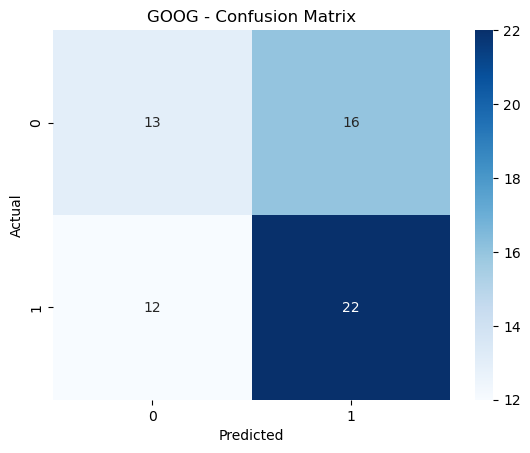

Classification Report for MSFT:
              precision    recall  f1-score   support

         0.0       0.52      0.50      0.51        28
         1.0       0.64      0.66      0.65        38

    accuracy                           0.59        66
   macro avg       0.58      0.58      0.58        66
weighted avg       0.59      0.59      0.59        66



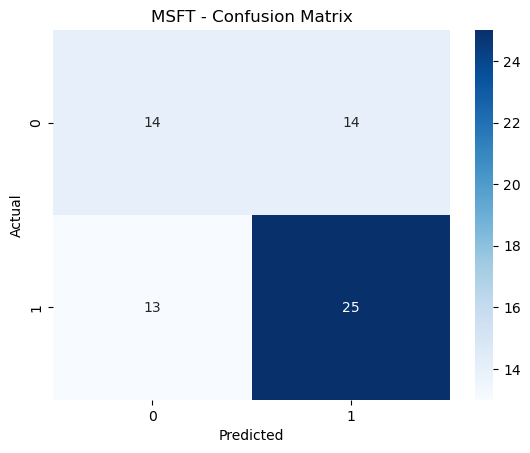

Classification Report for NVDA:
              precision    recall  f1-score   support

         0.0       0.38      0.23      0.29        26
         1.0       0.49      0.66      0.56        29

    accuracy                           0.45        55
   macro avg       0.43      0.44      0.42        55
weighted avg       0.43      0.45      0.43        55



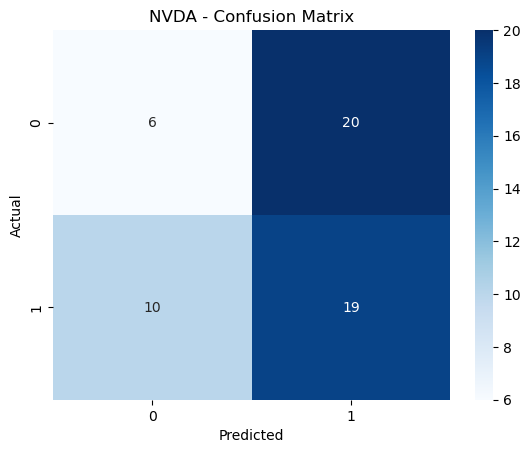

Classification Report for AMZN:
              precision    recall  f1-score   support

         0.0       0.66      0.61      0.64        44
         1.0       0.57      0.62      0.60        37

    accuracy                           0.62        81
   macro avg       0.62      0.62      0.62        81
weighted avg       0.62      0.62      0.62        81



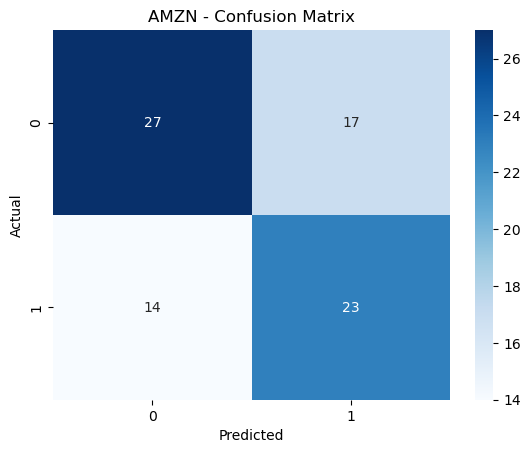

Classification Report for AAPL:
              precision    recall  f1-score   support

         0.0       0.42      0.51      0.46        37
         1.0       0.55      0.46      0.50        48

    accuracy                           0.48        85
   macro avg       0.49      0.49      0.48        85
weighted avg       0.49      0.48      0.48        85



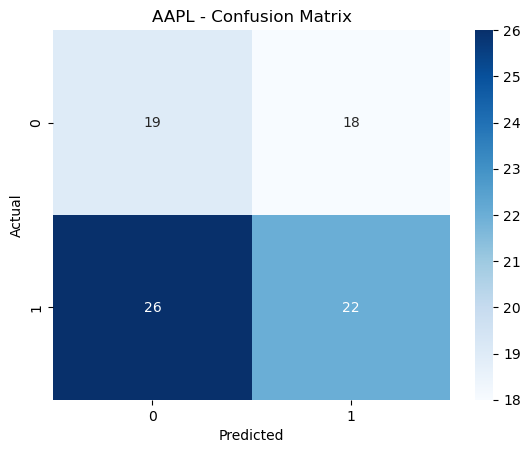

In [20]:
# # Prepare classification targets
# for ticker, df in stock_data.items():
#     df['Target'] = df.apply(classify_price_difference, axis=1)

# Train and evaluate classification models
classification_results = train_predict_trend(stock_data, Features, target= 'Trend')
